In [2]:
%matplotlib inline
from config import pword
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
# from config import password 

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
spark = SparkSession.builder.appName('pyspark_app') \
.config('spark.driver.extraClassPath','postgresql-42.2.11') \
.master('local[*]') \
.getOrCreate()


In [5]:
from pyspark import SparkFiles
from pyspark.sql.functions import to_date
from pyspark.sql.functions import round, col

In [6]:
#path for video games
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz"
#path for toys
# url2 = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Toys_v1_00.tsv.gz"

In [7]:
#add url file
spark.sparkContext.addFile(url)

In [8]:
df = spark.read.option("header", "true").csv(SparkFiles.get
                                             ("amazon_reviews_us_Video_Games_v1_00.tsv.gz"), inferSchema=True, sep='\t')

In [9]:
print(f'There are {df.count()} rows in the video game dataframe')

There are 1785997 rows in the video game dataframe


In [10]:
#create column in correct date format
df = df.withColumn("date", to_date(df['review_date']))

In [11]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: timestamp (nullable = true)
 |-- date: date (nullable = true)



In [12]:
#create reviews df
review_df = df.select(["review_id", "customer_id", "product_id", "product_parent", "date"])
review_df.show(5)

+--------------+-----------+----------+--------------+----------+
|     review_id|customer_id|product_id|product_parent|      date|
+--------------+-----------+----------+--------------+----------+
| RTIS3L2M1F5SM|   12039526|B001CXYMFS|     737716809|2015-08-31|
| R1ZV7R40OLHKD|    9636577|B00M920ND6|     569686175|2015-08-31|
|R3BH071QLH8QMC|    2331478|B0029CSOD2|      98937668|2015-08-31|
|R127K9NTSXA2YH|   52495923|B00GOOSV98|      23143350|2015-08-31|
|R32ZWUXDJPW27Q|   14533949|B00Y074JOM|     821342511|2015-08-31|
+--------------+-----------+----------+--------------+----------+
only showing top 5 rows



In [13]:
#create customer df with unique custy id
custy_df = df.groupBy('customer_id').count()

In [14]:
#rename count col
custy_df = custy_df.withColumnRenamed('count','customer_count')

In [15]:
custy_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   48670265|             1|
|   49103216|             2|
|    1131200|             1|
|   43076447|             2|
|   46261368|             1|
+-----------+--------------+
only showing top 5 rows



In [16]:
#create prod df with unique prod id
prod_df = df.select(["product_id", "product_title"])
prod_df = prod_df.dropDuplicates(['product_id'])

In [17]:
prod_df.count()

65792

In [18]:
#create vine df
vine_df = df.select(["review_id", "star_rating", "helpful_votes", "total_votes", "vine"])
vine_df.show(5)

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
| RTIS3L2M1F5SM|          5|            0|          0|   N|
| R1ZV7R40OLHKD|          5|            0|          0|   N|
|R3BH071QLH8QMC|          1|            0|          1|   N|
|R127K9NTSXA2YH|          3|            0|          0|   N|
|R32ZWUXDJPW27Q|          4|            0|          0|   N|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows



In [19]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://big-data-2.cpclfqan17p9.us-east-1.rds.amazonaws.com:5432/bd-homework"
config = {"user":"postgres", 
          "password": pword, 
          "driver":"org.postgresql.Driver"}

In [21]:
#write reviews to RDS
review_df.write.jdbc(url=jdbc_url, table='review_id_table', mode=mode, properties=config)

In [ ]:
#write customers
custy_df.write.jdbc(url=jdbc_url, table='customers', mode=mode, properties=config)

In [39]:
#write products
prod_df.write.jdbc(url=jdbc_url, table='products', mode=mode, properties=config)

In [40]:
#write vine
vine_df.write.jdbc(url=jdbc_url, table='vine_table', mode=mode, properties=config)

In [90]:
#create function to run analysis on reviews in ("Y") and out of ("N") vine program 
def vine_program(yes_no):
    df = vine_df.filter(vine_df["vine"] == yes_no).groupBy('star_rating').count()
    #rename count col
    df = df.withColumnRenamed('count','star_count')
    #count vine reviews
    total = df.groupBy().sum('star_count').collect()[0][0]
    print(f'There are {total} reviews with vine marker {yes_no}')
    #create percent of total column
    df = df.withColumn('star_pct',round(df['star_count']/total,4))
    #get total number of helpful votes by star rating
    df_help = vine_df.filter(vine_df["vine"] == yes_no).groupBy('star_rating').sum('helpful_votes')
    #rename helpful votes col
    df_help = df_help.withColumnRenamed('sum(helpful_votes)', 'helpful_votes')
    #join helpful votes to vine ratings
    df = df.join(df_help,['star_rating'])
    #create column which averages # of helpful votes by star
    df = df.withColumn('helpful_avg',round(df['helpful_votes']/df['star_count'],4))
    #count reviews by star that have no helpful votes
    no_help_df = vine_df.filter(vine_df["vine"]==yes_no).filter(vine_df['helpful_votes']==0).groupBy('star_rating').count()
    #rename count column
    no_help_df = no_help_df.withColumnRenamed('count', 'rvws_no_helpfuls')
    #join no_help df to df
    df = df.join(no_help_df,['star_rating'])
    #calcualte pct of reviews with no helpful votes
    df = df.withColumn('pct_no_help',round(df['rvws_no_helpfuls']/df['star_count'],4))
    #order by star rating
    df = df.orderBy(df['star_rating'].asc())
    #show schema
    df.printSchema()
    global pandas_df
    pandas_df = df.toPandas()
    if yes_no == "Y":
        color = "blue"
        title = "Vine"
    else:
        color = "red"
        title = "Non-Vine"
        
    #plot number of reviews by star rating
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['star_count'], color =color)
    plt.title(f"{title} Reviews", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("# of Ratings", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"{title}reviews.png")
    #plot average of helpful votes per review by star ratings
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['helpful_avg'], color =color)
    plt.title(f"Avg # of Helpful Votes per {title} Review", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("Average", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"{title}_help_avg.png")
    #plot percentage of reviews which received no helpful votes by star ratings
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['pct_no_help'], color =color)
    plt.title(f"Pct of {title} Reviews Receiving No Helpful Votes", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("Percent", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"{title}_no_help.png")
    
    return df.show()
    
    

There are 4291 reviews with vine marker Y
root
 |-- star_rating: integer (nullable = true)
 |-- star_count: long (nullable = false)
 |-- star_pct: double (nullable = true)
 |-- helpful_votes: long (nullable = true)
 |-- helpful_avg: double (nullable = true)
 |-- rvws_no_helpfuls: long (nullable = false)
 |-- pct_no_help: double (nullable = true)

+-----------+----------+--------+-------------+-----------+----------------+-----------+
|star_rating|star_count|star_pct|helpful_votes|helpful_avg|rvws_no_helpfuls|pct_no_help|
+-----------+----------+--------+-------------+-----------+----------------+-----------+
|          1|        60|   0.014|          103|     1.7167|              23|     0.3833|
|          2|       194|  0.0452|          448|     2.3093|              95|     0.4897|
|          3|       718|  0.1673|         1419|     1.9763|             389|     0.5418|
|          4|      1712|   0.399|         3862|     2.2558|             980|     0.5724|
|          5|      1607|  0.

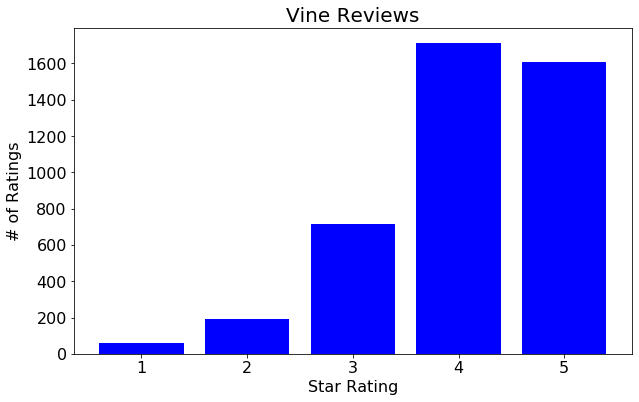

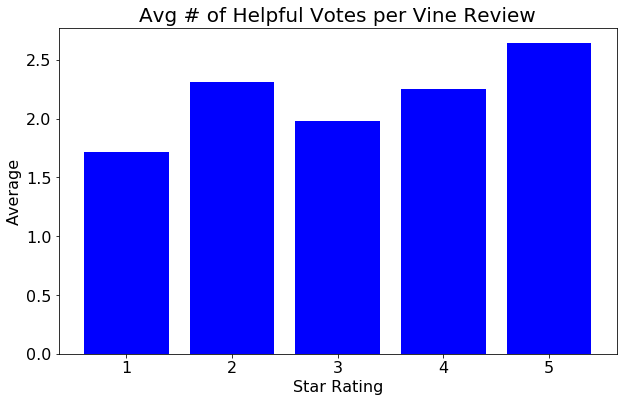

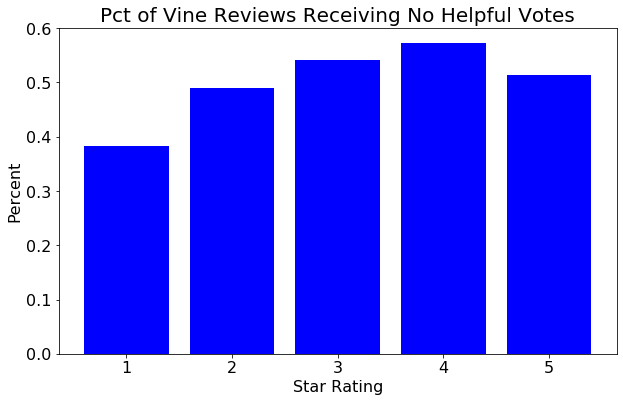

In [91]:
vine_program("Y")

There are 1781706 reviews with vine marker N
root
 |-- star_rating: integer (nullable = true)
 |-- star_count: long (nullable = false)
 |-- star_pct: double (nullable = true)
 |-- helpful_votes: long (nullable = true)
 |-- helpful_avg: double (nullable = true)
 |-- rvws_no_helpfuls: long (nullable = false)
 |-- pct_no_help: double (nullable = true)

+-----------+----------+--------+-------------+-----------+----------------+-----------+
|star_rating|star_count|star_pct|helpful_votes|helpful_avg|rvws_no_helpfuls|pct_no_help|
+-----------+----------+--------+-------------+-----------+----------------+-----------+
|          1|    192106|  0.1078|       911501|     4.7448|           71538|     0.3724|
|          2|     94603|  0.0531|       310776|     3.2851|           42661|     0.4509|
|          3|    153146|   0.086|       408177|     2.6653|           84295|     0.5504|
|          4|    316534|  0.1777|       687691|     2.1726|          191390|     0.6046|
|          5|   1025317| 

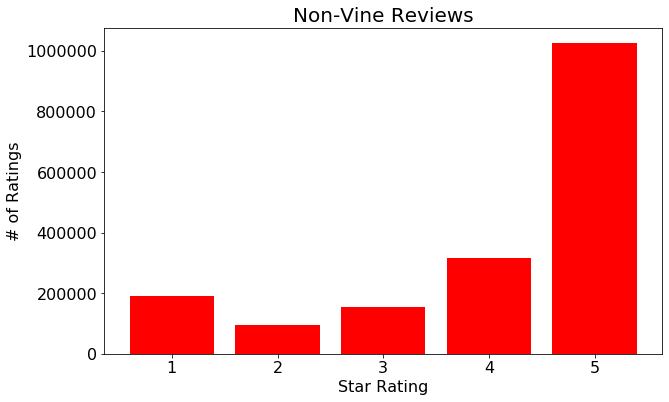

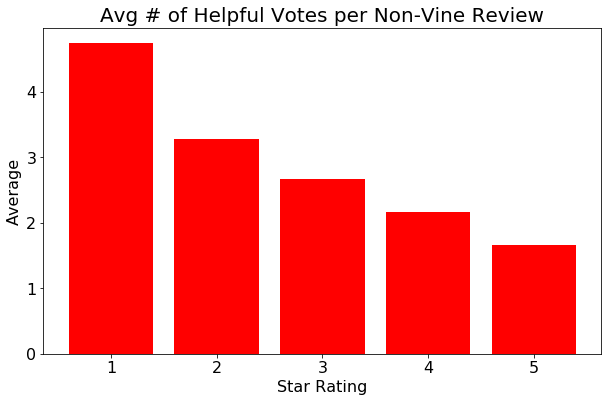

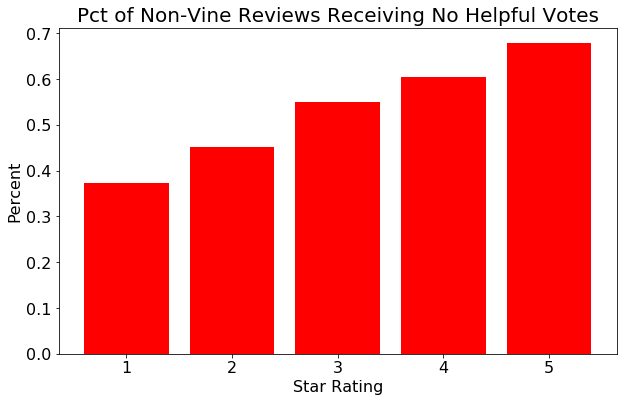

In [92]:
vine_program("N")

In [22]:
pandas_df

,star_rating,star_count,star_pct,helpful_votes,helpful_avg,rvws_no_helpfuls,pct_no_help
0,1,60,0.0140,103,1.7167,23,0.3833
1,2,194,0.0452,448,2.3093,95,0.4897
2,3,718,0.1673,1419,1.9763,389,0.5418
3,4,1712,0.3990,3862,2.2558,980,0.5724
4,5,1607,0.3745,4245,2.6416,827,0.5146


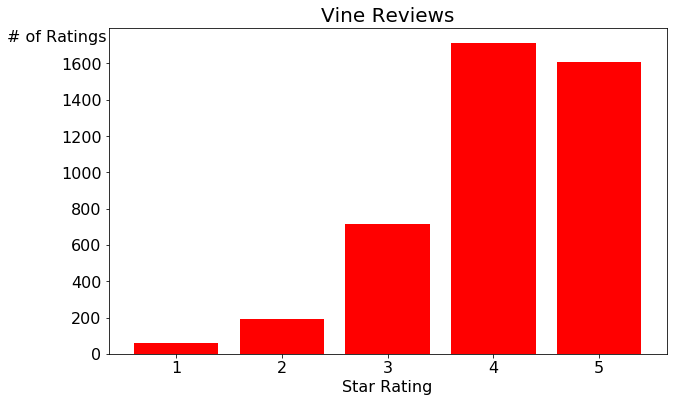

In [80]:
plt.figure(figsize=(10,6))
plt.bar(pandas_df['star_rating'],pandas_df['star_count'], color ="red")
plt.title("Vine Reviews", fontsize=20)
plt.xlabel("Star Rating", fontsize=16)
plt.ylabel("# of Ratings", fontsize=16, rotation= "horizontal", y =0.95
          )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("test.png")
